In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import corner
from tqdm import tqdm

import sys
sys.path.append('../../dev/wdphoto')

from corecomposition import build_catalog, measure_radius, build, analyze
import wdphoto
import configparser

G = 6.674e-11
mass_sun = 1.9884e30
radius_sun = 6.957e8
c = 2.99e8

## Build The Catalog

In [2]:
catpath = 'elbadry.csv'
confpath = 'data/gold.ini'
outpath = 'data/test.csv'

basecat = Table.read(catpath)
config = configparser.ConfigParser()
config.read(confpath)

['data/gold.ini']

In [3]:
basecat, targets, engine_keys = build(config, basecat)

Building Catalog


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:13<00:00,  1.48s/it]


Found 380 WD+MS Wide Binaries

Measuring Radii


100%|██████████| 380/380 [01:47<00:00,  3.54it/s]



Fit Report:
Warwick failed=1.05%
CO_Hrich failed=5.79%
ONe_Hrich failed=3.42%
CO_Hdef failed=1.05%
ONe_Hdef failed=2.11%
Total failed=13.42%
Found 5 High Mass WD+MS Wide Binaries


## Check The Radii Using MCMC

In [5]:
bands = config['radius']['pyphot_bands'].split(' ')

co_hrich_model = wdphoto.LaPlataInterpolator(bands, massive_params = ('CO', 'Hrich'))
co_hdef_model = wdphoto.LaPlataInterpolator(bands, massive_params = ('CO', 'Hdef'))

one_hrich_model = wdphoto.LaPlataInterpolator(bands, massive_params = ('ONe', 'Hrich'))
one_hdef_model = wdphoto.LaPlataInterpolator(bands, massive_params = ('ONe', 'Hdef'))

base_model = wdphoto.LaPlataInterpolator(bands)

In [6]:
i = 1
obs_mag = np.array([targets[i]['wd_phot_bp_mean_mag'], targets[i]['wd_phot_rp_mean_mag']])
e_obs_mag = np.array([targets[i]['wd_e_bpmag'], targets[i]['wd_e_rpmag']])
distance = targets['r_med_geo'][i]

In [10]:
engine = wdphoto.PhotometryEngine(co_hdef_model, assume_mrr=True)
radius, e_radius, teff, e_teff, logg, e_logg, result = engine(obs_mag, e_obs_mag, distance, method='emcee', 
                                                              **dict(is_weighted=True, steps = 10000, float_behavior = 'chi2'))

100%|██████████| 10000/10000 [03:44<00:00, 44.53it/s]


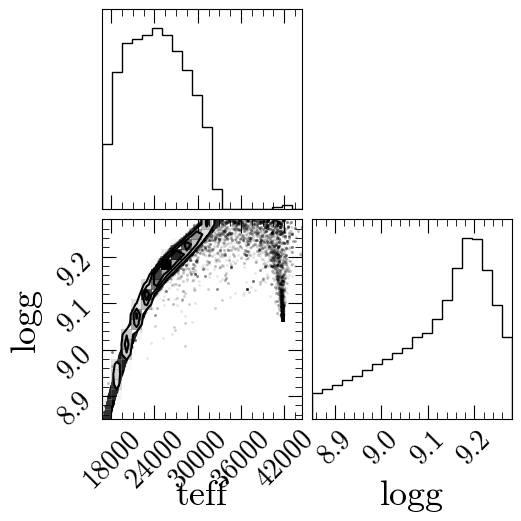

In [11]:
emcee_plot = corner.corner(result.flatchain, labels=result.var_names)

## Plot Theoretical Models

In [ ]:
teff = np.linspace(5000, 75000, 5)
logg = np.linspace(7, 9.3, 200)

co_hrich_radius = []
co_hrich_mass = []
co_hrich_vg = []
co_hdef_radius = []
co_hdef_mass = []
co_hdef_vg = []

one_hrich_radius = []
one_hrich_mass = []
one_hrich_vg = []
one_hdef_radius = []
one_hdef_mass = []
one_hdef_vg = []

base_radius = []
base_mass = []
base_vg = []

for j in tqdm(range(len(teff))):
    radii = [co_hrich_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]    
    co_hrich_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    co_hrich_mass.append(masses)
    co_hrich_radius.append(radii)

    radii = [co_hdef_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]
    co_hdef_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    co_hdef_mass.append(masses)
    co_hdef_radius.append(radii)

    radii = [one_hrich_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]    
    one_hrich_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    one_hrich_mass.append(masses)
    one_hrich_radius.append(radii)

    radii = [one_hdef_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]
    one_hdef_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    one_hdef_mass.append(masses)
    one_hdef_radius.append(radii)

    radii = [base_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]
    base_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    base_mass.append(masses)
    base_radius.append(radii)

co_hrich_radius = np.array(co_hrich_radius)
co_hrich_mass = np.array(co_hrich_mass)
co_hrich_vg = np.array(co_hrich_vg)
co_hdef_radius = np.array(co_hdef_radius)
co_hdef_mass = np.array(co_hdef_mass)
co_hdef_vg = np.array(co_hdef_vg)

one_hrich_radius = np.array(one_hrich_radius)
one_hrich_mass = np.array(one_hrich_mass)
one_hrich_vg = np.array(one_hrich_vg)
one_hdef_radius = np.array(one_hdef_radius)
one_hdef_mass = np.array(one_hdef_mass)
one_hdef_vg = np.array(one_hdef_vg)

base_radius = np.array(base_radius)
base_mass = np.array(base_mass)
base_vg = np.array(base_vg)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 15.41it/s]


Text(0.5, 0, 'Mass $[M_\\odot]$')

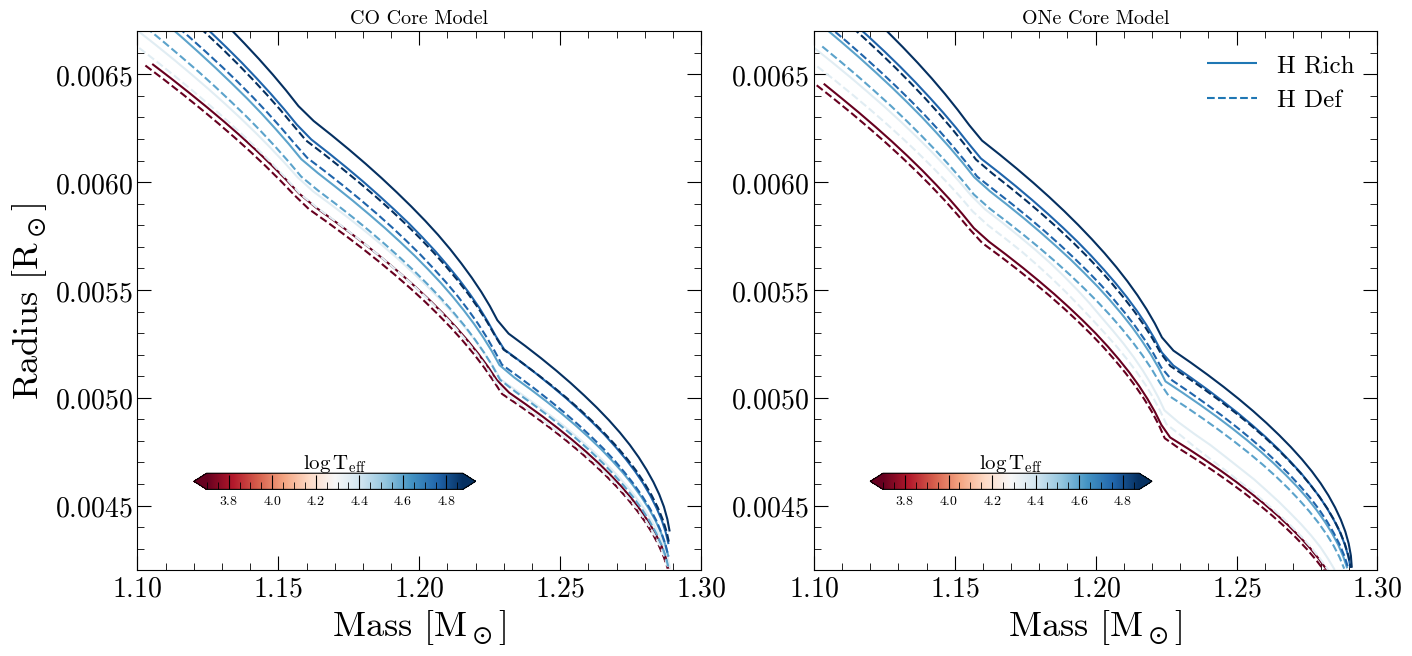

In [ ]:
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 7))

co_hrich_stack = [np.column_stack([x,y]) for x, y in zip(co_hrich_mass, co_hrich_radius)]
co_hdef_stack = [np.column_stack([x,y]) for x, y in zip(co_hdef_mass, co_hdef_radius)]

one_hrich_stack = [np.column_stack([x,y]) for x, y in zip(one_hrich_mass, one_hrich_radius)]
one_hdef_stack = [np.column_stack([x,y]) for x, y in zip(one_hdef_mass, one_hdef_radius)]


ax1.set_xlim(1.1, 1.3)
ax1.set_ylim(0.0042, 0.0067)
ax1.set_title('CO Core Model')

line_collection = LineCollection(co_hrich_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='CO H Rich')
ax1.add_collection(line_collection)
line_collection = LineCollection(co_hdef_stack, array=np.log10(teff), cmap='RdBu', ls = '--', label='CO H Def')
ax1.add_collection(line_collection)

cbaxes = ax1.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(line_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax1.set_xlabel(r'Mass $[M_\odot]$')
ax1.set_ylabel(r'Radius $[R_\odot]$')


ax2.set_xlim(1.1, 1.3)
ax2.set_ylim(0.0042, 0.0067)
ax2.set_title('ONe Core Model')

line_collection = LineCollection(one_hrich_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='H Rich')
ax2.add_collection(line_collection)
line_collection = LineCollection(one_hdef_stack, array=np.log10(teff), cmap='RdBu', ls = '--', label='H Def')
ax2.add_collection(line_collection)

cbaxes = ax2.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(line_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax2.legend(framealpha=0)
ax2.set_xlabel(r'Mass $[M_\odot]$')


Text(0.5, 0, 'Mass $[M_\\odot]$')

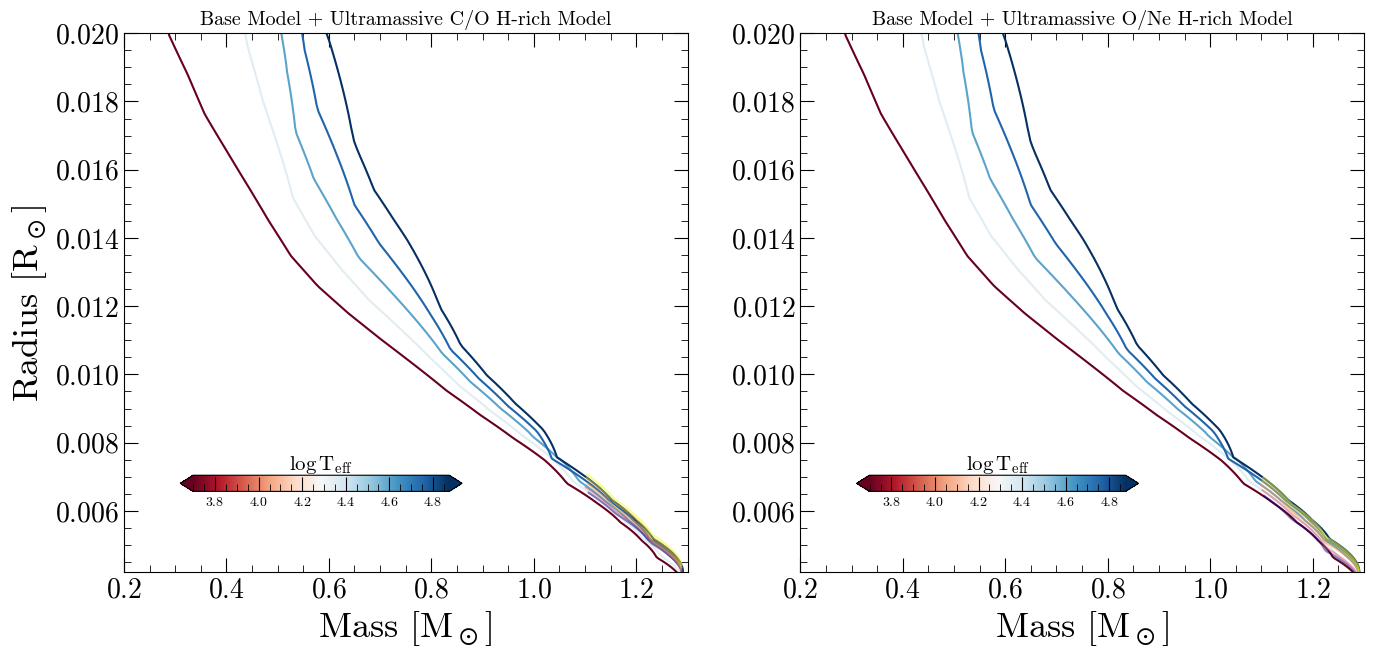

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(16, 7))

base_stack = [np.column_stack([x,y]) for x, y in zip(base_mass, base_radius)]
co_hrich_stack = [np.column_stack([x,y]) for x, y in zip(co_hrich_mass, co_hrich_radius)]
one_hrich_stack = [np.column_stack([x,y]) for x, y in zip(one_hrich_mass, one_hrich_radius)]


ax1.set_xlim(0.2, 1.3)
ax1.set_ylim(0.0042, 0.02)
ax1.set_title('Base Model + Ultramassive C/O H-rich Model')

base_collection = LineCollection(base_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='CO H Rich')
ax1.add_collection(base_collection)
line_collection = LineCollection(co_hrich_stack, array=np.log10(teff), cmap='plasma', ls = '-', label='CO H Rich', alpha = 0.5)
ax1.add_collection(line_collection)

cbaxes = ax1.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(base_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax1.set_xlabel(r'Mass $[M_\odot]$')
ax1.set_ylabel(r'Radius $[R_\odot]$')




ax2.set_xlim(0.2, 1.3)
ax2.set_ylim(0.0042, 0.02)
ax2.set_title('Base Model + Ultramassive O/Ne H-rich Model')

base_collection = LineCollection(base_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='CO H Rich')
ax2.add_collection(base_collection)
line_collection = LineCollection(one_hrich_stack, array=np.log10(teff), cmap='plasma', ls = '-', label='CO H Rich', alpha = 0.5)
ax2.add_collection(line_collection)

cbaxes = ax2.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(base_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax2.set_xlabel(r'Mass $[M_\odot]$')



Text(0.5, 0, 'Radius $[R_\\odot]$')

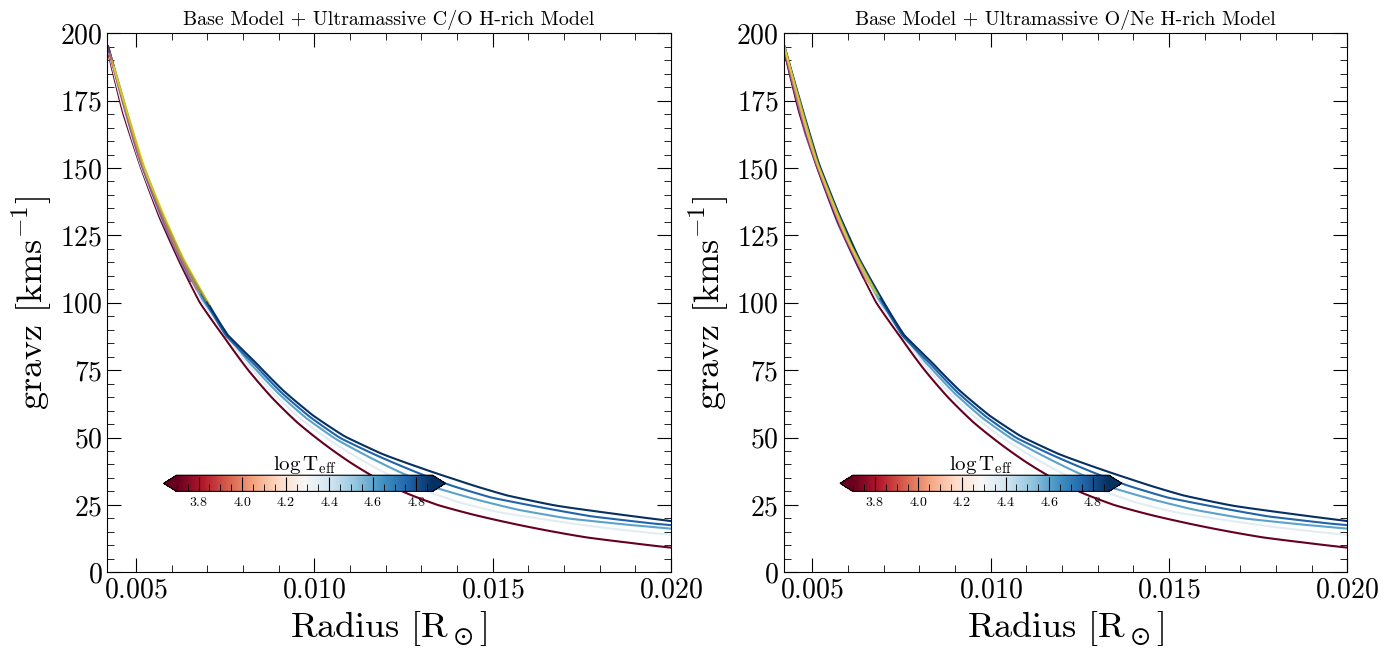

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(16, 7))


base_stack = [np.column_stack([x,y]) for x, y in zip(base_radius, base_vg)]
co_hrich_stack = [np.column_stack([x,y]) for x, y in zip(co_hrich_radius, co_hrich_vg)]
one_hrich_stack = [np.column_stack([x,y]) for x, y in zip(one_hdef_radius, one_hdef_vg)]

ax1.set_xlim(0.0042, 0.02)
ax1.set_ylim(0, 200)
ax1.set_title('Base Model + Ultramassive C/O H-rich Model')

base_collection = LineCollection(base_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='CO H Rich')
ax1.add_collection(base_collection)
line_collection = LineCollection(co_hrich_stack, array=np.log10(teff), cmap='plasma', ls = '-', label='CO H Rich', alpha = 0.5)
ax1.add_collection(line_collection)

cbaxes = ax1.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(base_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax1.set_ylabel(r'gravz $[km s^{-1}]$')
ax1.set_xlabel(r'Radius $[R_\odot]$')




ax2.set_xlim(0.0042, 0.02)
ax2.set_ylim(0, 200)
ax2.set_title('Base Model + Ultramassive O/Ne H-rich Model')

base_collection = LineCollection(base_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='CO H Rich')
ax2.add_collection(base_collection)
line_collection = LineCollection(one_hrich_stack, array=np.log10(teff), cmap='plasma', ls = '-', label='CO H Rich', alpha = 0.5)
ax2.add_collection(line_collection)

cbaxes = ax2.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(base_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax2.set_ylabel(r'gravz $[km s^{-1}]$')
ax2.set_xlabel(r'Radius $[R_\odot]$')